## <center> Tutorial: Graph Neural Networks for Social Networks Using PyTorch on AWS SageMaker 

## Data Exploration

In [1]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import AddTrainValTestMask as masking
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx


Using backend: pytorch


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import json
import os
import collections

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import itertools
from itertools import combinations 


import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 

from sklearn import metrics
 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch_geometric.data import Data
from torch_geometric.data import DataLoader as DataLoaderGraph
from torch_geometric.data import Dataset as DatasetGraph
from torch_geometric.data import Batch as BatchGraph
from torch_geometric.transforms import AddTrainValTestMask as masking

from torch_geometric.nn import GCNConv, BatchNorm, SAGEConv, SGConv, ChebConv
from torch_geometric.utils.convert import to_networkx

import networkx as nx


#from torch.utils.data import DataLoader as DataLoaderUtil
#from torch.utils.data import Dataset as DatasetUtil 
#from sklearn import manifold musae_git_edges.csv

In [2]:
with open("data/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)

edges=pd.read_csv("data/musae_git_edges.csv")
target_df=pd.read_csv("data/musae_git_target.csv")#.to_numpy()[:,2]

In [34]:
print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())



5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [4]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]

print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


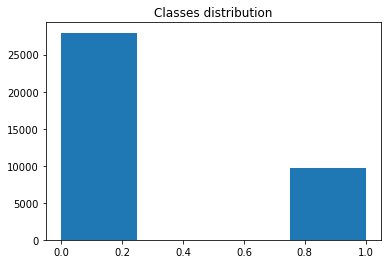

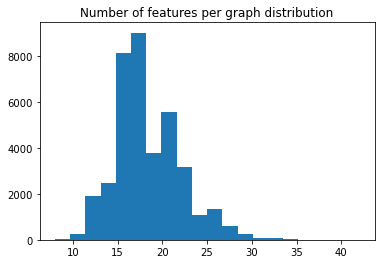

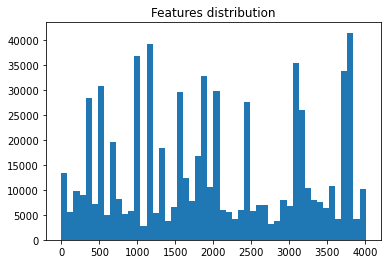

In [33]:
plt.hist(target_df.ml_target,bins=4,);
plt.title("Classes distribution")
plt.show()

plt.hist(feat_counts,bins=20)
plt.title("Number of features per graph distribution")
plt.show()

plt.hist(feats,bins=50)
plt.title("Features distribution")
plt.show()

In [6]:
counter=collections.Counter(feats)
print(list(counter.keys())[:10])
print(list(counter.values())[:10])
print(list(counter.keys())[-10:])
print(list(counter.values())[-10:])
#data_encoded

[1574, 3773, 3571, 2672, 2478, 2534, 3129, 3077, 1171, 2045]
[5045, 12726, 2486, 298, 165, 510, 22075, 28188, 24958, 21449]
[936, 172, 875, 3548, 2745, 793, 1941, 464, 2616, 3124]
[1, 2, 1, 2, 1, 1, 1, 1, 1, 1]


1574

In [7]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    
    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)


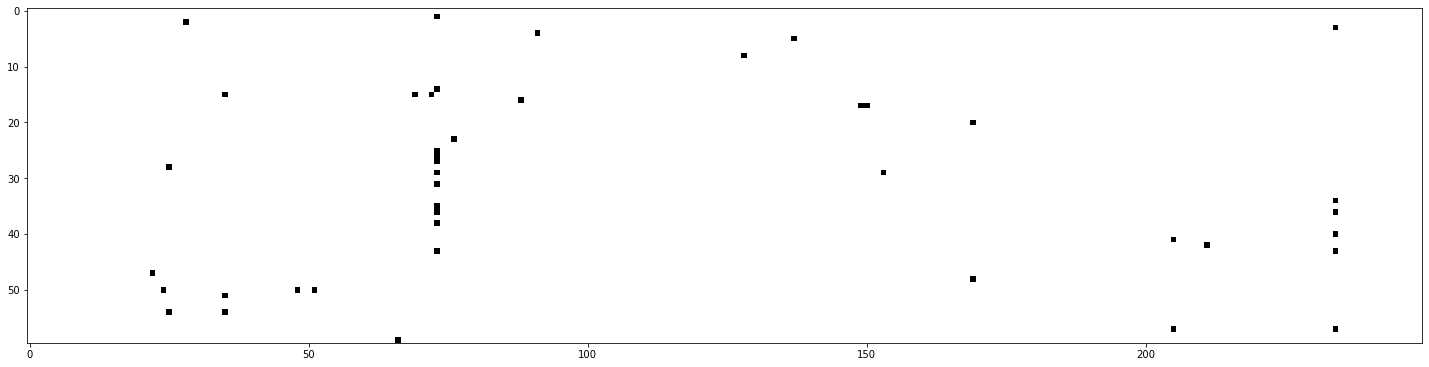

In [37]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');
#plt.grid()

In [10]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [11]:
#g_top_draw = Data(x=node_features, y=node_labels, edge_index=edge_index0)

def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
        
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")
        


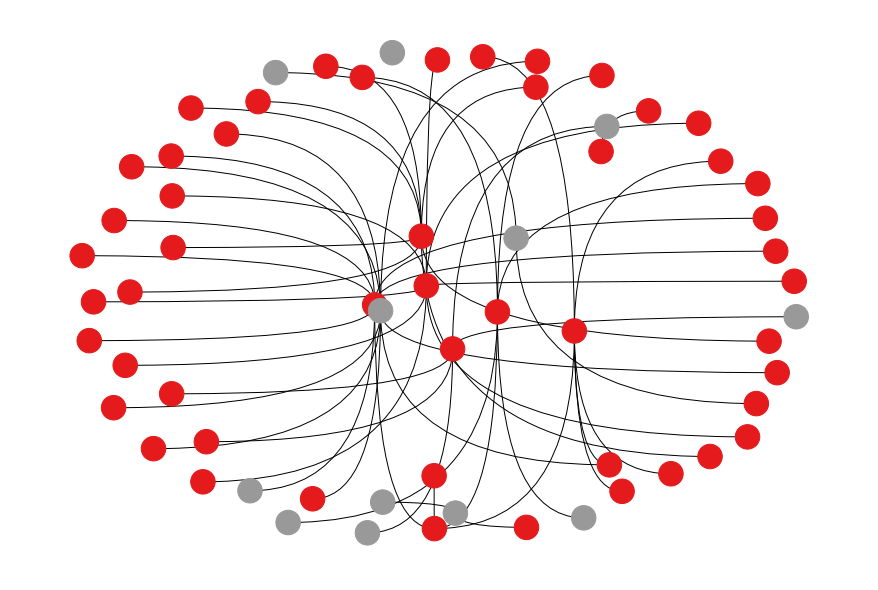

In [12]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)

## Model

In [13]:
data_encoded,_=encode_data(light=False)

In [15]:
g=construct_graph(data_encoded=data_encoded,light=False)

In [40]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
g=msk(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

Data(edge_index=[2, 578006], test_mask=[37700], train_mask=[37700], val_mask=[37700], x=[37700, 4005], y=[37700])

training samples 3770
validation samples 11310
test samples 22620


In [29]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()


        self.conv1 = GCNConv(num_of_feat, f)

        self.conv2 = GCNConv(f, 2)


    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
          
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        return x

In [25]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)    

In [26]:
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)    

In [27]:
def train_social(net,data,epochs=10,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    
    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]
    
    for ep in range(epochs+1):
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]
        
        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss]
        
        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy]

        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy

    plt.plot(train_losses)  
    plt.plot(val_losses)
    plt.plot(test_losses)  

    plt.show()
    
    plt.plot(train_accuracies) 
    plt.plot(val_accuracies)
    plt.plot(test_accuracies) 
    plt.show()

        
    
    

Epoch 1/50, Train_Loss: 0.6921, Train_Accuracy: 0.5186, Val_Accuracy: 0.5245, Test_Accuracy: 0.5118
Epoch 2/50, Train_Loss: 1.5516, Train_Accuracy: 0.7446, Val_Accuracy: 0.7374, Test_Accuracy: 0.7433
Epoch 3/50, Train_Loss: 0.5812, Train_Accuracy: 0.7485, Val_Accuracy: 0.7419, Test_Accuracy: 0.7470
Epoch 5/50, Train_Loss: 0.5734, Train_Accuracy: 0.7549, Val_Accuracy: 0.7601, Test_Accuracy: 0.7552
Epoch 6/50, Train_Loss: 0.4349, Train_Accuracy: 0.8647, Val_Accuracy: 0.8548, Test_Accuracy: 0.8569
Epoch 17/50, Train_Loss: 0.3625, Train_Accuracy: 0.8634, Val_Accuracy: 0.8565, Test_Accuracy: 0.8582
Epoch 18/50, Train_Loss: 0.3529, Train_Accuracy: 0.8684, Val_Accuracy: 0.8593, Test_Accuracy: 0.8618
Epoch 19/50, Train_Loss: 0.3436, Train_Accuracy: 0.8735, Val_Accuracy: 0.8624, Test_Accuracy: 0.8634
Epoch 20/50, Train_Loss: 0.3378, Train_Accuracy: 0.8745, Val_Accuracy: 0.8630, Test_Accuracy: 0.8631
Epoch 21/50, Train_Loss: 0.3370, Train_Accuracy: 0.8743, Val_Accuracy: 0.8638, Test_Accuracy: 0.

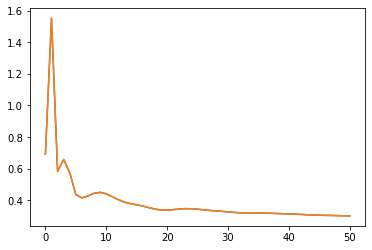

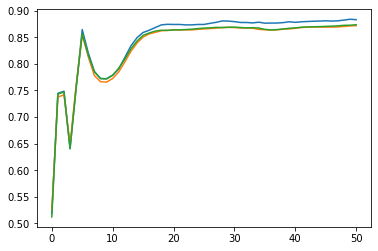

In [30]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
train_social(net,g,epochs=50,lr=0.1)